# Домашнее задание № 9

In [1]:
!pip install rusenttokenize
!pip install tokenizers

In [2]:
import pandas as pd
from rusenttokenize import ru_sent_tokenize

import matplotlib.pyplot as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers import decoders
from tqdm.autonotebook import tqdm

/tmp/ipykernel_35/2143326536.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Задание 1 (10 баллов)

Визуализируйте attention для одного любого текста после нескольких последовательных эпох обучения, чтобы проанализировать как модель учится понимать текст. 
Для этого вам понадобится так изменить код модели из семинара, чтобы Block класс возвращал attention активации (последнее значение wei), а также все остальные классы, которые вызывают Block, чтобы они ожидали, что модель вернет не только out но и wei. В самом верхнеуровневом классе BigramLanguageModel вы можете добавить атрибут last_attentions и в forward перезаписывать его значения последним значением attention (но можно придумать и другой способ). После каждой эпохи вызовите модель на одном примере из датасета и сохраните last_attentions во внешнюю переменную, чтобы потом отдельно заняться визуализацией. Визуализируйте attentions как heatmap'ы (например в searborn). У вас будет attention матрица для каждого слоя и для каждого head в модели. Для каждой нужно будет сделать свой хитмап.
Должно получиться что-то похожее на (только несколько для каждой эпохи)
![](https://www.kdnuggets.com/wp-content/uploads/How_to_Visualize_Model_Internals_and_Attention_in_Hugging_Face_Transformers_3.png)

## Данные

In [3]:
data = pd.read_csv('https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/data/lenta_40k.csv.zip')
sentences = []
for text in data.text.values:
    sentences.extend(ru_sent_tokenize(text))
    
f = open('corpus.txt', 'w')
for sent in sentences:
    f.write(sent + '\n')
f.close()

sentences = open('corpus.txt').read().splitlines()

In [4]:
tokenizer = Tokenizer(BPE())
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(special_tokens=["[PAD]", "[BOS]", "[EOS]"], end_of_word_suffix="</w>")
tokenizer.train(files=["corpus.txt"], trainer=trainer)
tokenizer.save("tokenizer")

In [5]:
tokenizer = Tokenizer.from_file("tokenizer")
tokenizer.decoder = decoders.BPEDecoder()
vocab_size = tokenizer.get_vocab_size()

In [6]:
def encode(text, tokenizer):
    return [tokenizer.token_to_id('[BOS]')] + tokenizer.encode(text).ids + [tokenizer.token_to_id('[EOS]')]

In [7]:
PAD_IDX = tokenizer.token_to_id('[PAD]')

In [8]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, sentences, tokenizer, max_len=32):
        self.encoded_texts = [torch.LongTensor(encode(sent, tokenizer)[-max_len:]) for sent in sentences]

        self.X = torch.nn.utils.rnn.pad_sequence(self.encoded_texts, padding_value=PAD_IDX, batch_first=True)
        self.length = len(self.encoded_texts)
    
    def __len__(self):
        return self.length

    def __getitem__(self, index):
        x = self.X[index][:-1]
        y = self.X[index][1:]
    
        mask = x!=PAD_IDX

        return x, y, mask

In [9]:
n = int(0.9*len(sentences)) # first 90% will be train, rest val
sentences_train = sentences[:n]
sentences_val = sentences[n:]

In [10]:
MAX_LEN = 64

## Обучение

In [11]:
training_set = Dataset(sentences_train, tokenizer, MAX_LEN)
val_set = Dataset(sentences_val, tokenizer, MAX_LEN)

In [12]:
training_generator = torch.utils.data.DataLoader(training_set, batch_size=200, shuffle=True, )
val_generator = torch.utils.data.DataLoader(training_set, batch_size=200, shuffle=False)

In [13]:
# hyperparameters
block_size = MAX_LEN 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 64 
n_head = 4
n_layer = 4
dropout = 0.0

In [14]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C ** -0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        if mask is not None:
            wei = wei.masked_fill(~mask.unsqueeze(1), float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out, wei


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        weis = []
        outs = []
        for h in self.heads:
            out_head, wei_head = h(x, mask)
            outs.append(out_head)
            weis.append(wei_head)
        out = torch.cat(outs, dim=-1)
        out = self.dropout(self.proj(out))
        return out, weis

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x, mask=None):
        x_norm = self.ln1(x)
        attn_output, attn_weights = self.sa(x_norm, mask)
        x = x + attn_output
        x_norm2 = self.ln2(x)
        x = x + self.ffwd(x_norm2)
        return x, attn_weights


In [15]:
class BigramLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.ModuleList([Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.last_attentions = []

    def forward(self, idx, targets=None, mask=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))
        x = tok_emb + pos_emb

        attentions = []
        for block in self.blocks:
            x, attn = block(x, mask=mask)
            attentions.append(attn)
        self.last_attentions = attentions

        x = self.ln_f(x)
        logits = self.lm_head(x)

        loss = None
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens, stop_token):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            if idx_next.item() == stop_token:
                break
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


In [16]:
model = BigramLanguageModel()
m = model.to(device)
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

4.073392 M parameters


In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [18]:
def train(model, iterator, optimizer, print_every=10):
    epoch_loss = []
    model.train()  

    for i, (xs, ys, mask) in enumerate(iterator):
        optimizer.zero_grad()   
        logits, loss = model(xs.to(device), ys.to(device), mask.to('cuda')) 
        
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
        
        if not (i+1) % print_every:
            print(f'Loss: {torch.Tensor(epoch_loss).mean(-1)}')
        
    return torch.Tensor(epoch_loss).mean(-1)

def evaluate(model, iterator):
    epoch_loss = []
    model.eval()  
    with torch.no_grad():
        for xs, ys, mask in iterator:   
            logits, loss = model(xs.to(device), ys.to(device), mask.to('cuda'))     
            epoch_loss.append(loss.item())  
            
    return torch.Tensor(epoch_loss).mean(-1)

In [19]:
attentions_by_epoch = []
train_losses = []
eval_losses = []

sample_x, sample_y, sample_mask = next(iter(val_generator))
sample_x = sample_x.to(device)
sample_mask = sample_mask.to(device)

for i in range(30):
    print(i)
    train_losses.append(train(model, training_generator, optimizer, 100))
    eval_loss = evaluate(model, val_generator)
    print('Eval - ', eval_loss.item())
    eval_losses.append(eval_loss)

    model.eval()
    with torch.no_grad():
        _, _ = model(sample_x, mask=sample_mask)
        epoch_attentions = []
        for layer in model.last_attentions:
            layer_attn = [head_wei[0].cpu().numpy() for head_wei in layer]
            epoch_attentions.append(layer_attn)
        attentions_by_epoch.append(epoch_attentions)

    for _ in range(3):
        pred = model.generate(torch.LongTensor([[tokenizer.token_to_id('[BOS]')]]).to('cuda'), 200, tokenizer.token_to_id('[EOS]'))
        print(tokenizer.decoder.decode([tokenizer.id_to_token(i) for i in pred.detach().cpu().numpy()[0]][1:-1]))

0
Loss: 5.046870231628418
Loss: 4.10356330871582
Loss: 3.7551188468933105
Loss: 3.570838689804077
Loss: 3.4491922855377197
Loss: 3.3571338653564453
Loss: 3.281683921813965
Loss: 3.221616506576538
Loss: 3.168198823928833
Loss: 3.11971378326416
Loss: 3.074993371963501
Loss: 3.036536455154419
Loss: 2.998565673828125
Loss: 2.9654335975646973
Loss: 2.93507719039917
Loss: 2.9058775901794434
Loss: 2.878959894180298
Loss: 2.8540115356445312
Loss: 2.8310651779174805
Loss: 2.808255910873413
Loss: 2.787482738494873
Loss: 2.767685890197754
Eval -  2.33072566986084
Две захвата 90 - летний указал российской столице стал Эслалетняя РР в Доля обовити
Махвай режиссер отменила цвевского реализации депозивси опубликовал уль здоровья Борис Немцов и описающегося для октина чиновников Ииголов « Юсвишка - километре », « МиГ
Бранломы в 34 километрах о это подтоллла губернаторов Масхадова возбуждено в ходе и непосредтеля страны , должны были проведены программное мужа , сообщает издание от Роспотребнадзора
1
L

KeyboardInterrupt: 

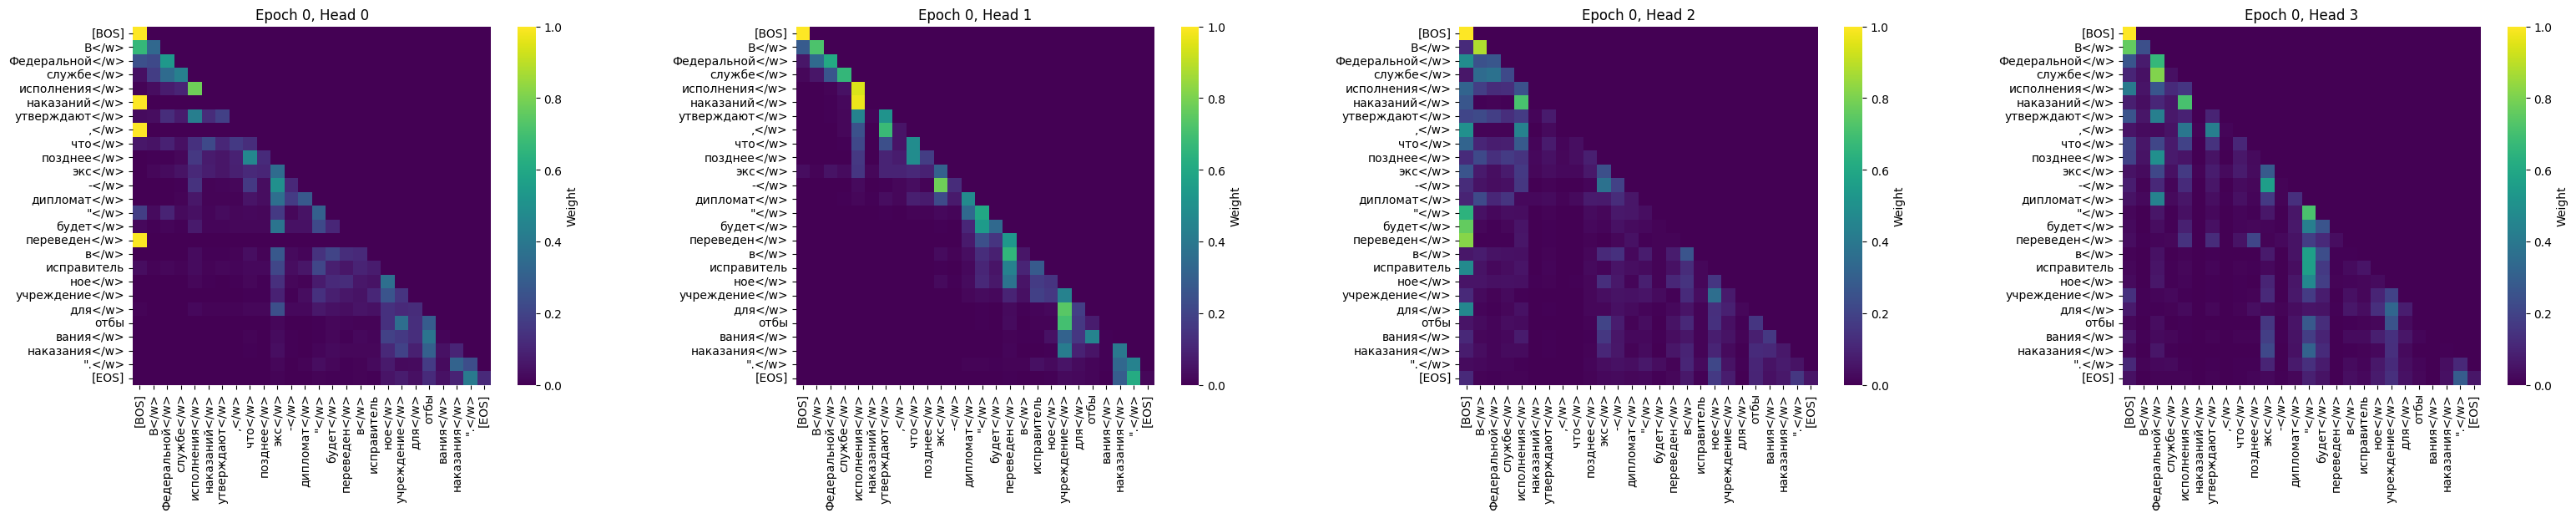

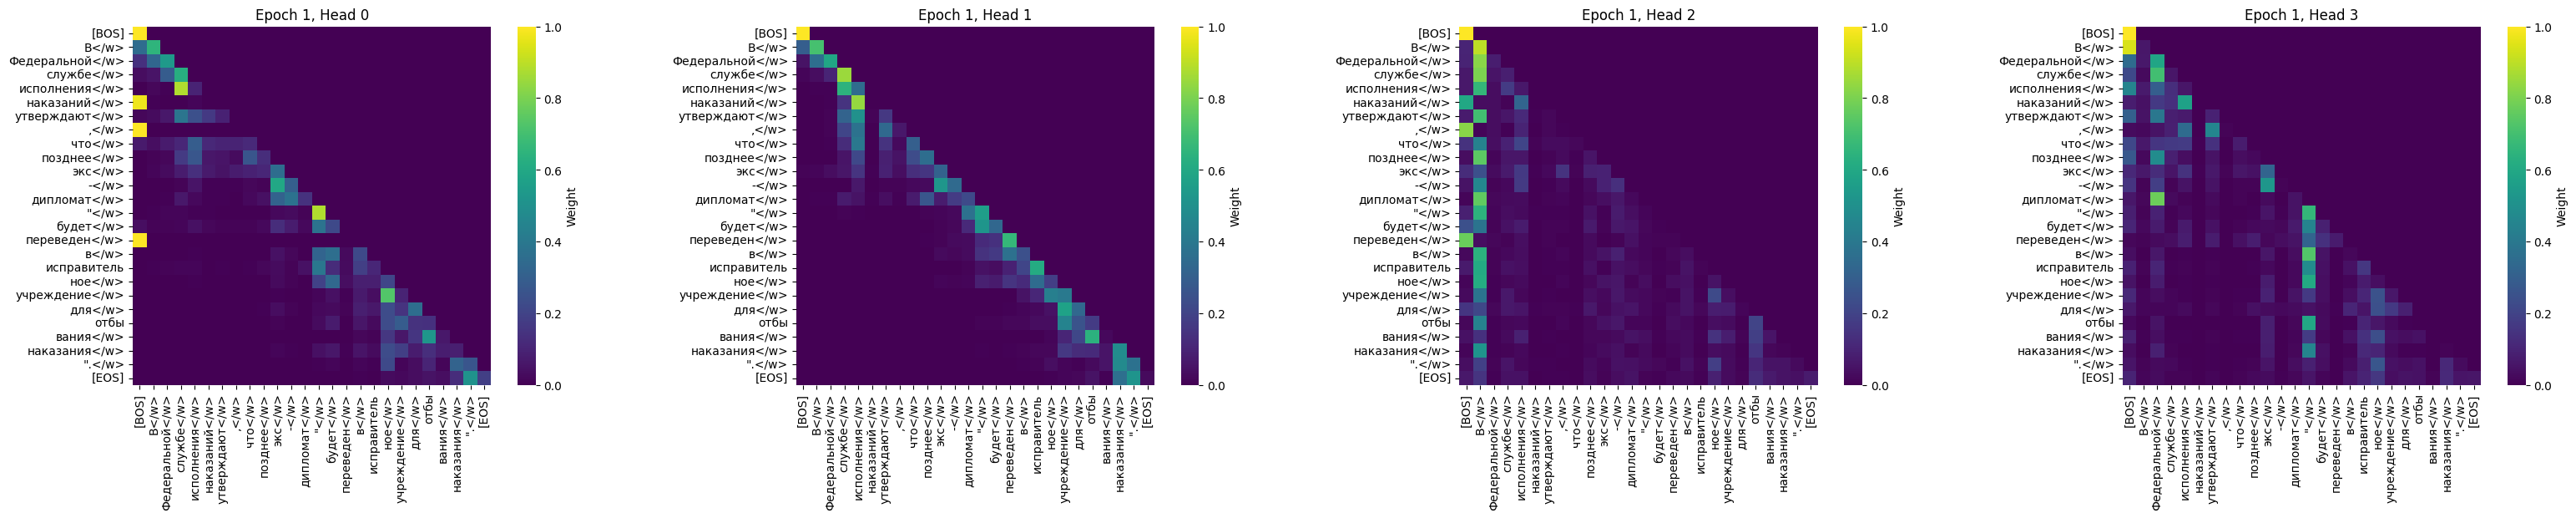

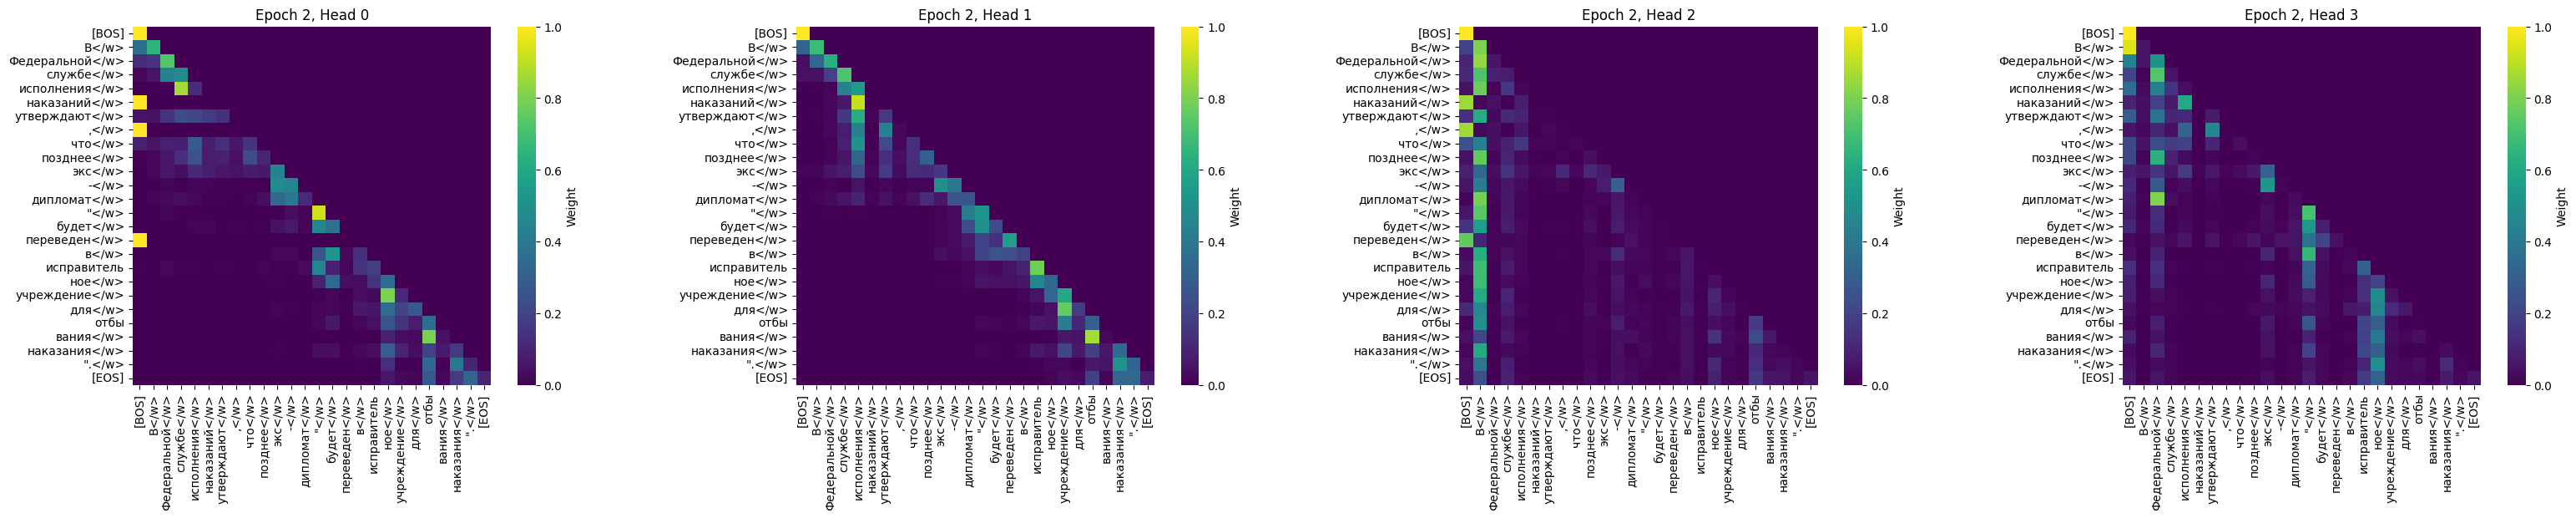

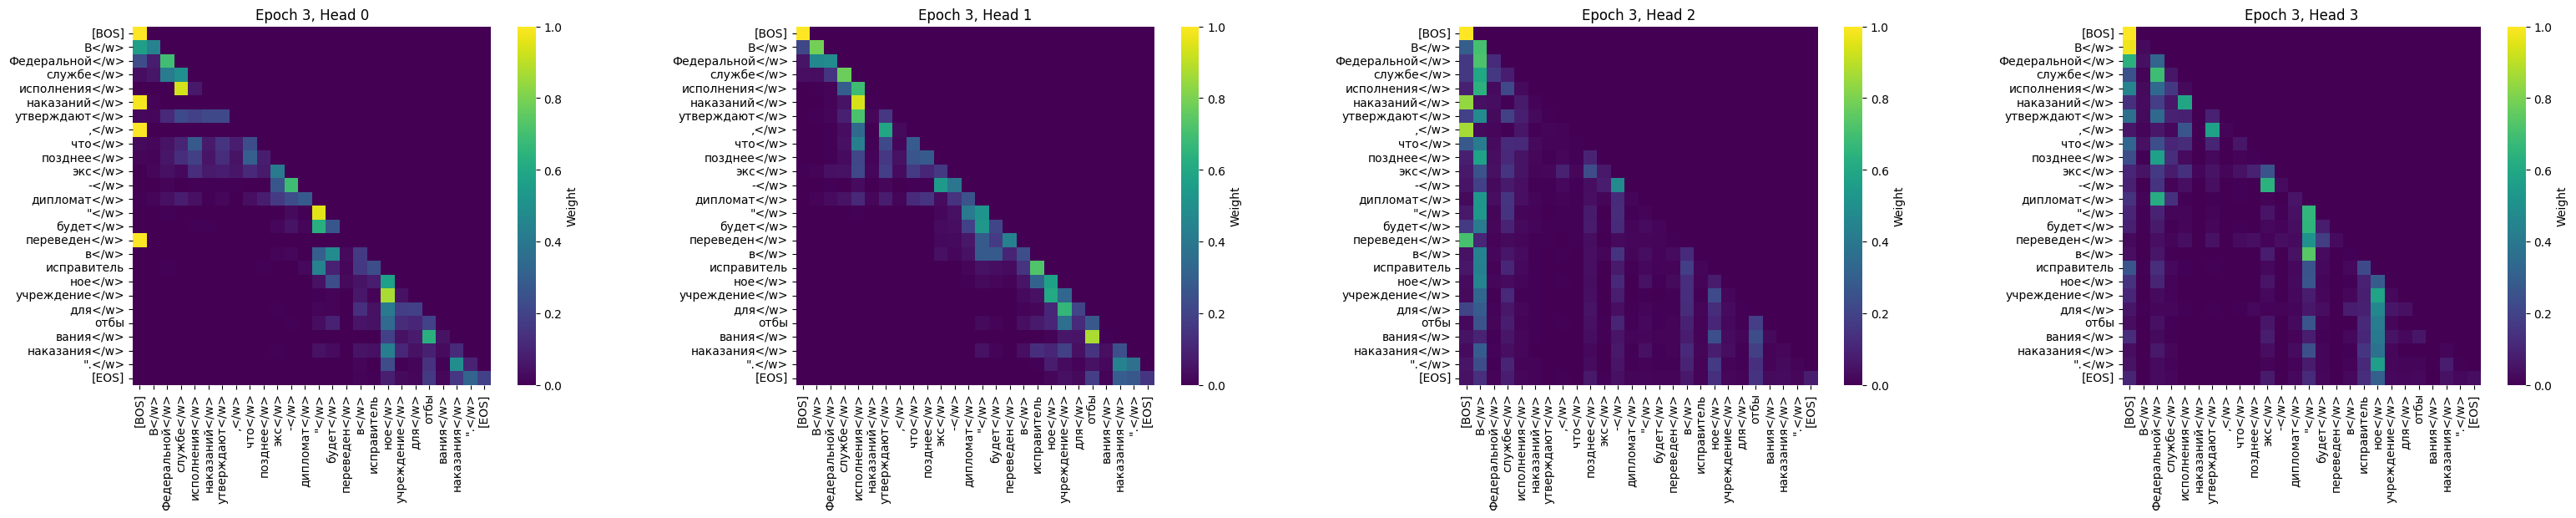

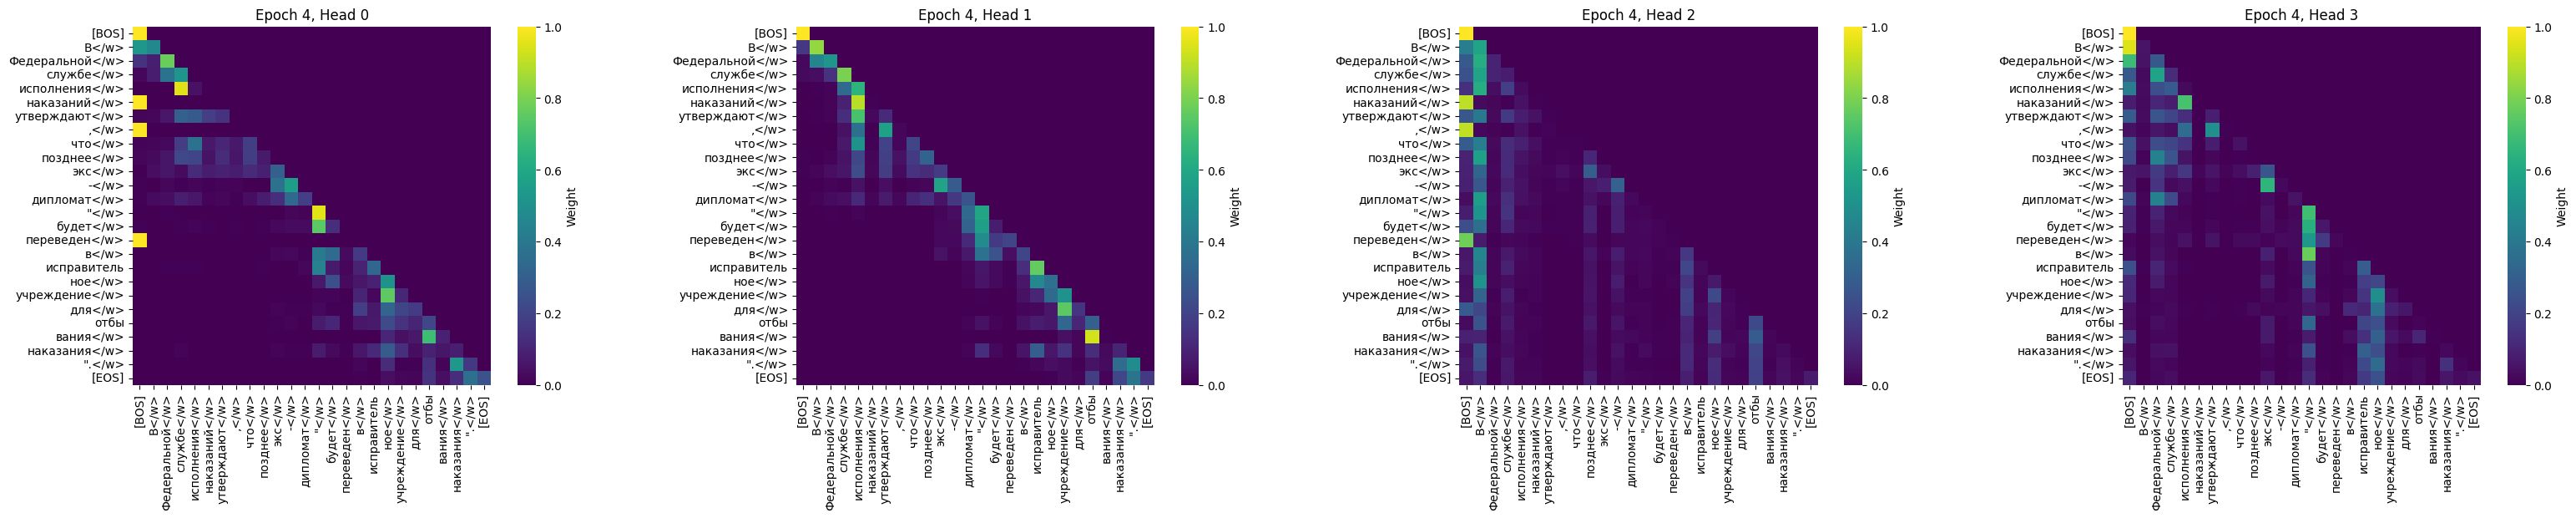

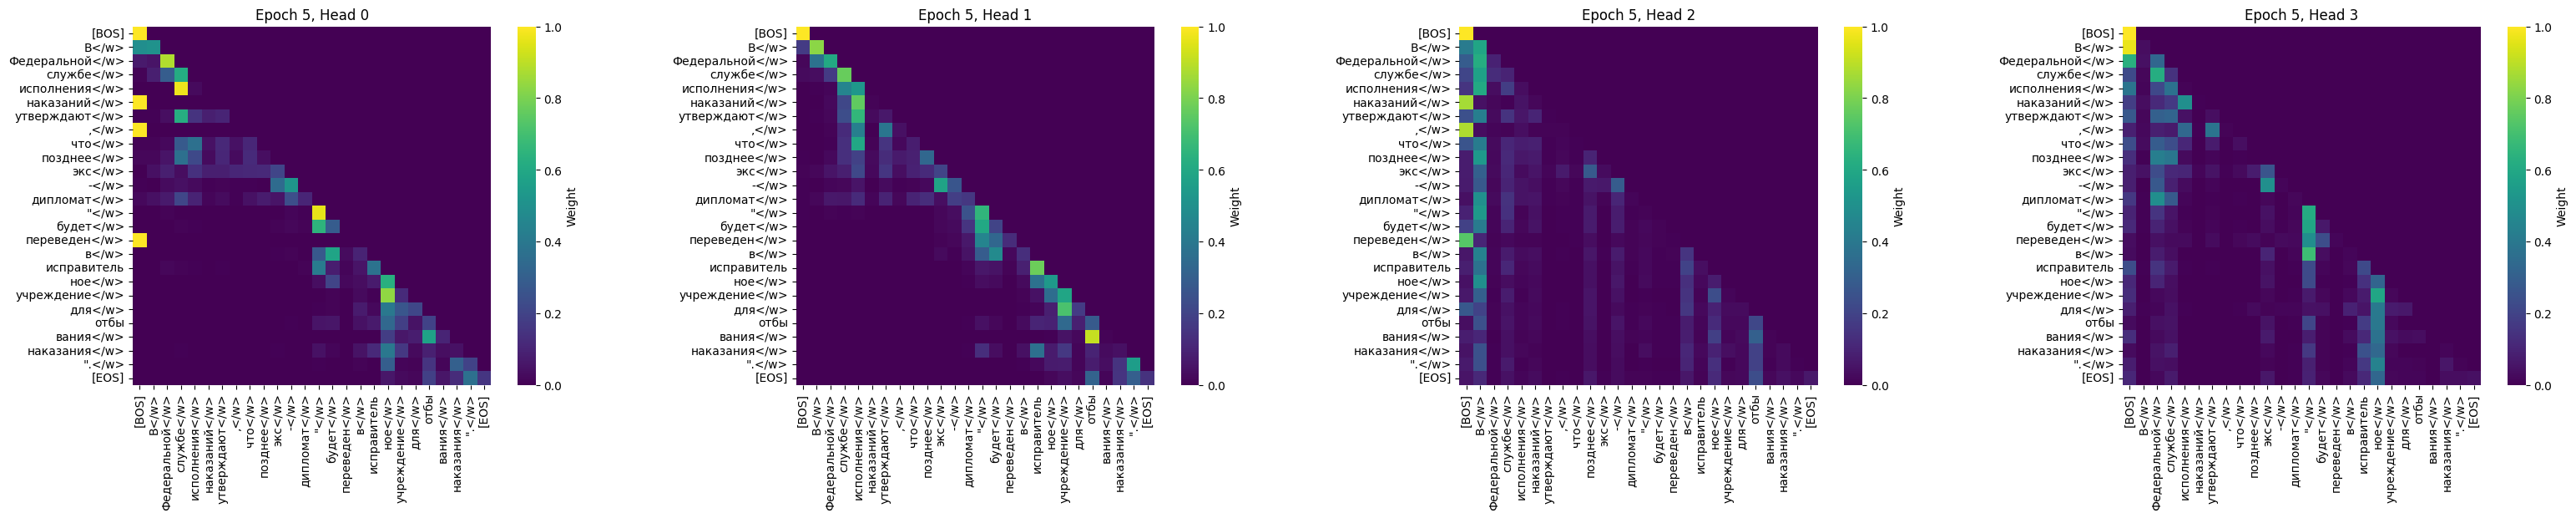

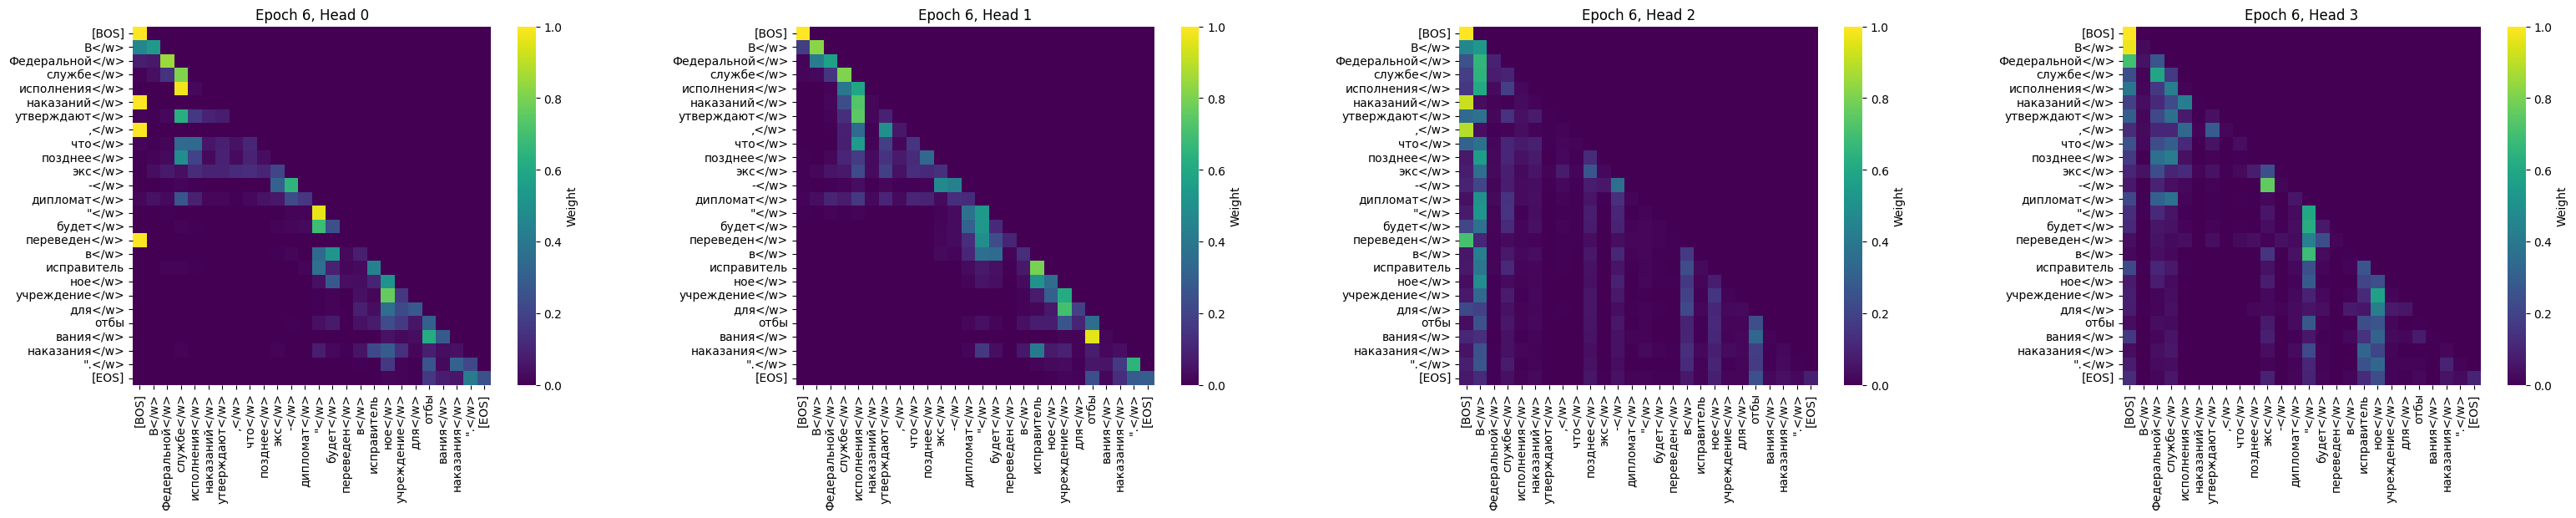

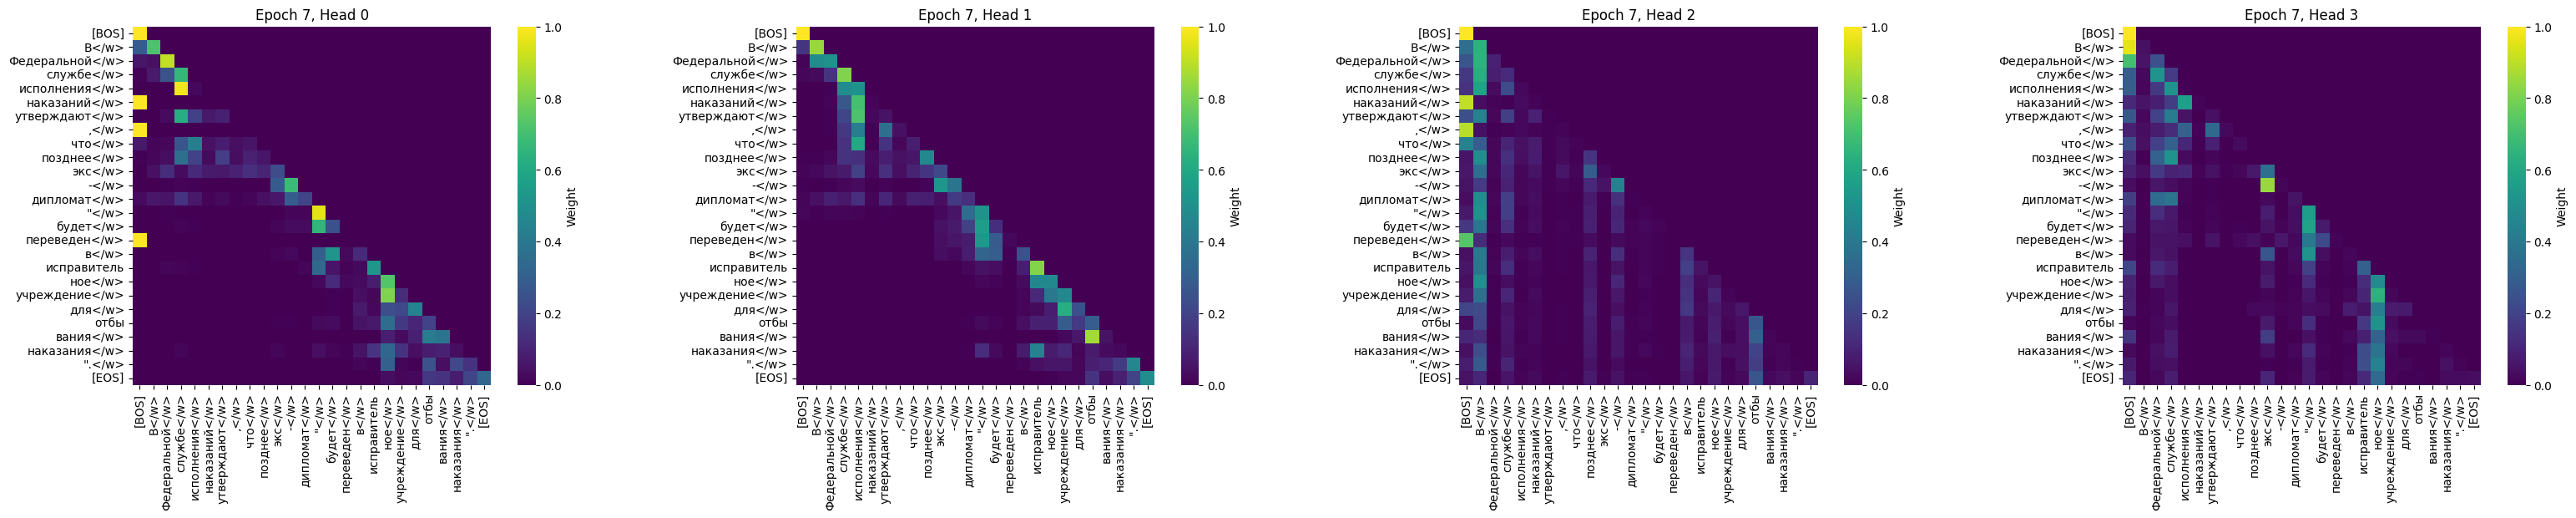

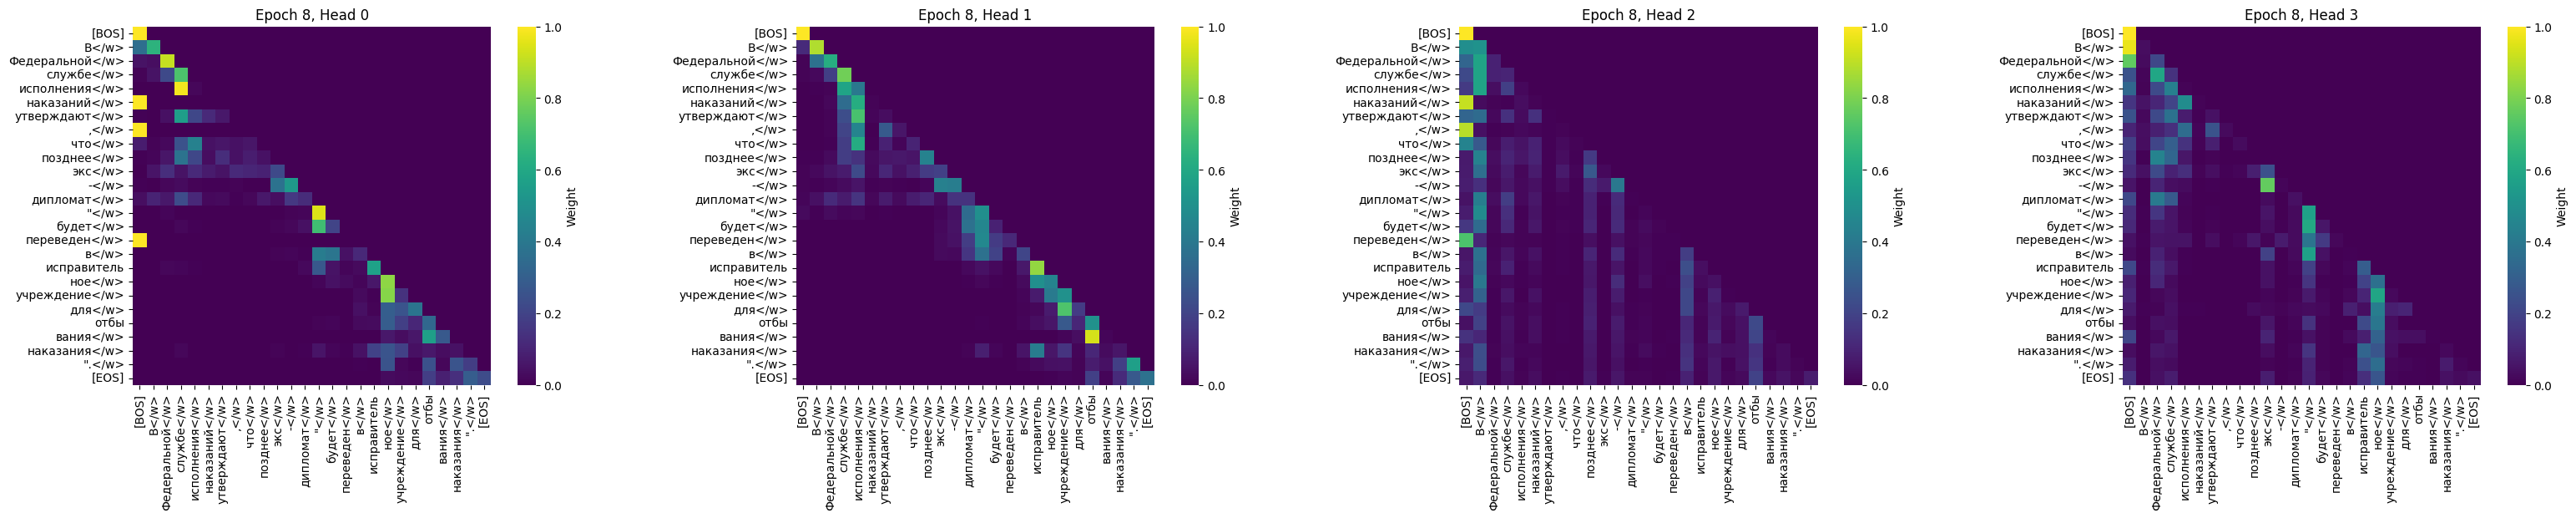

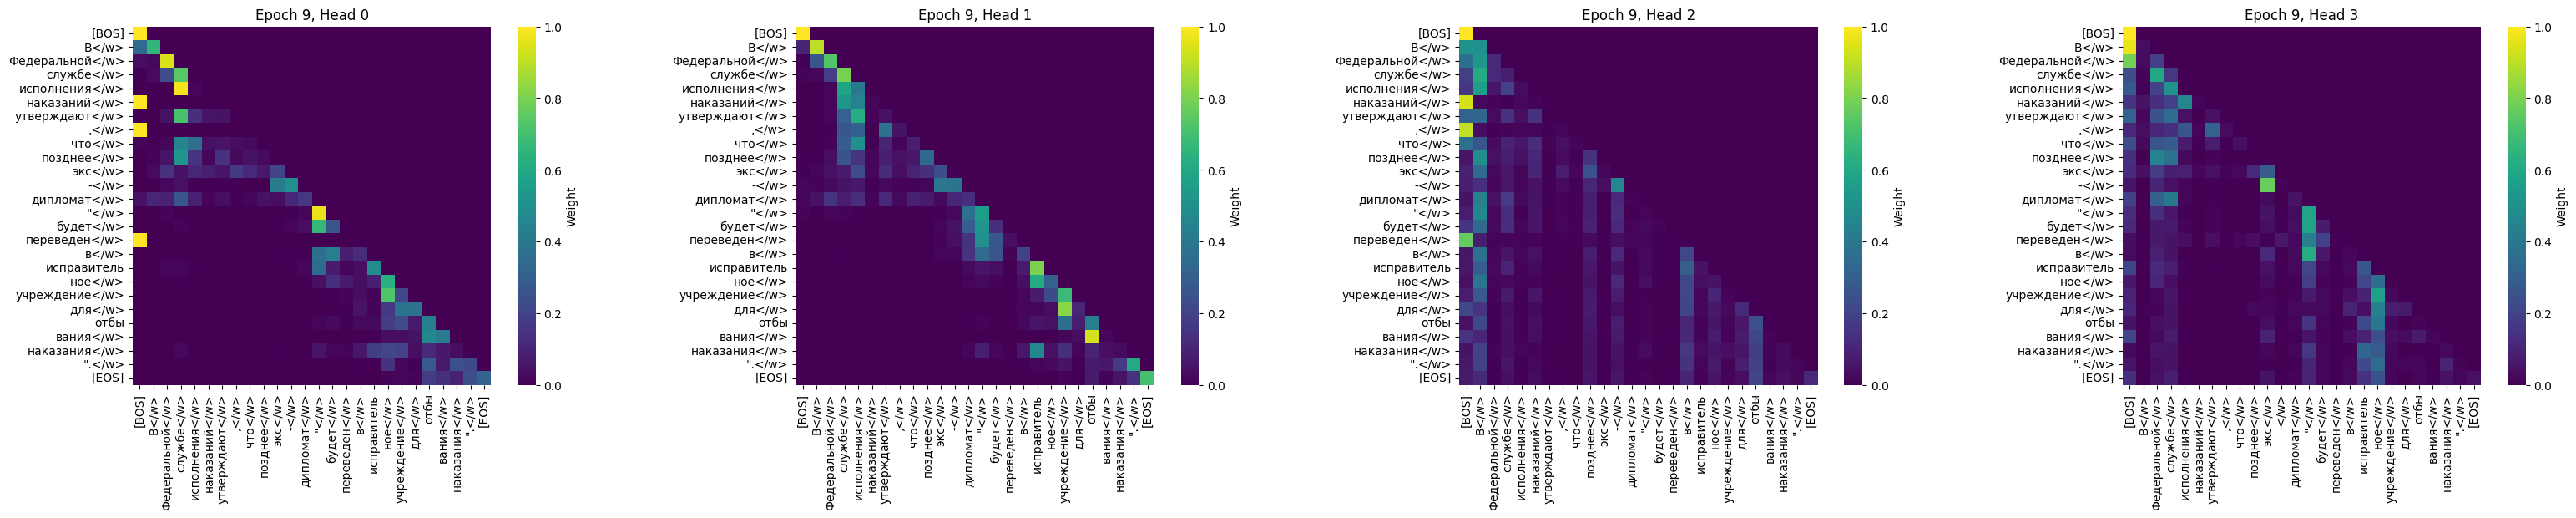

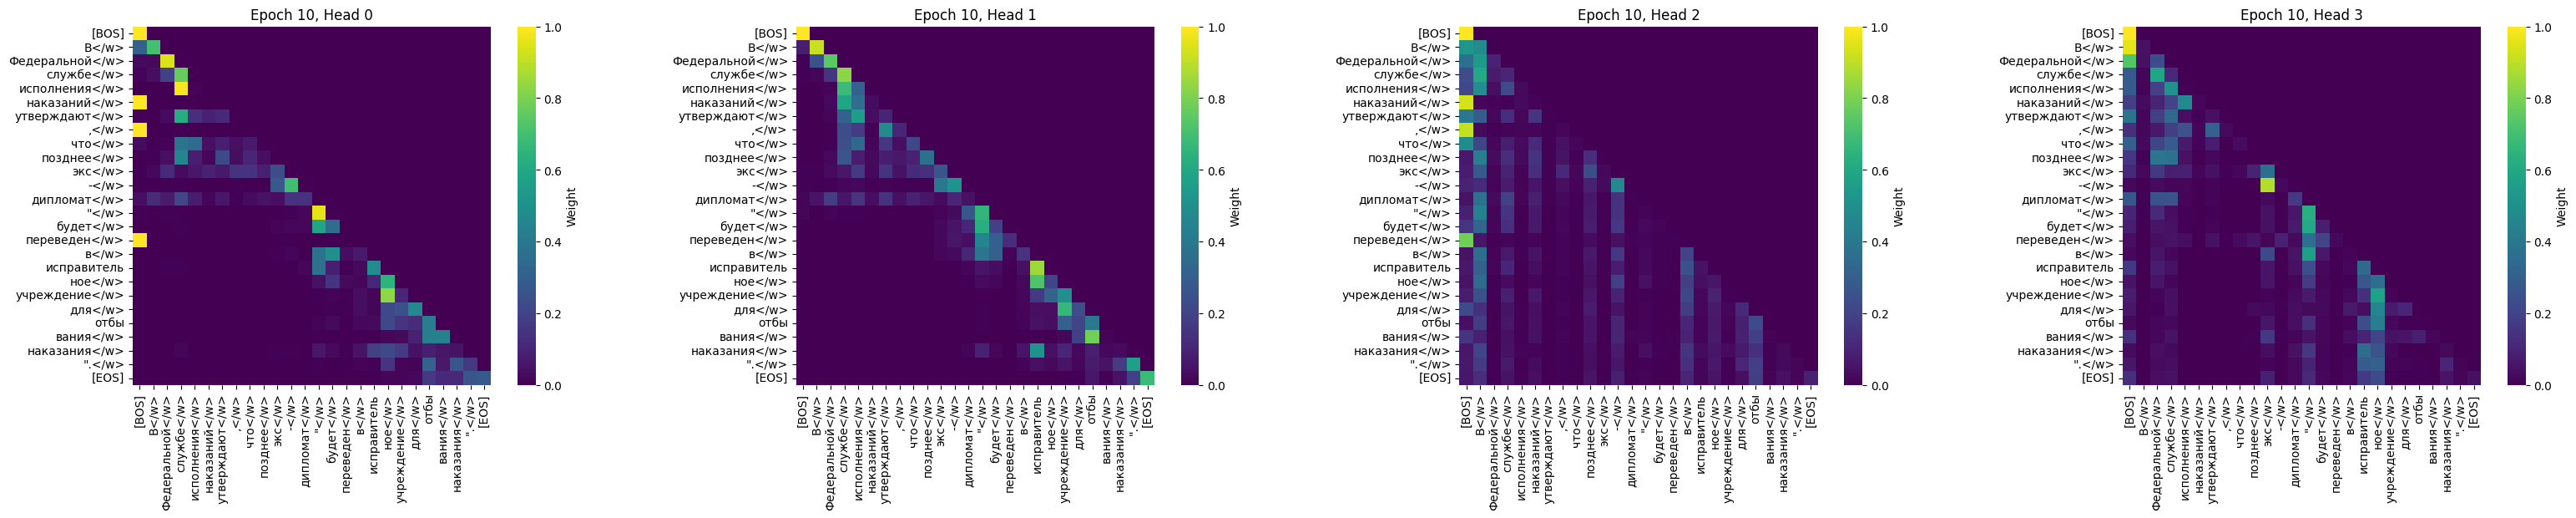

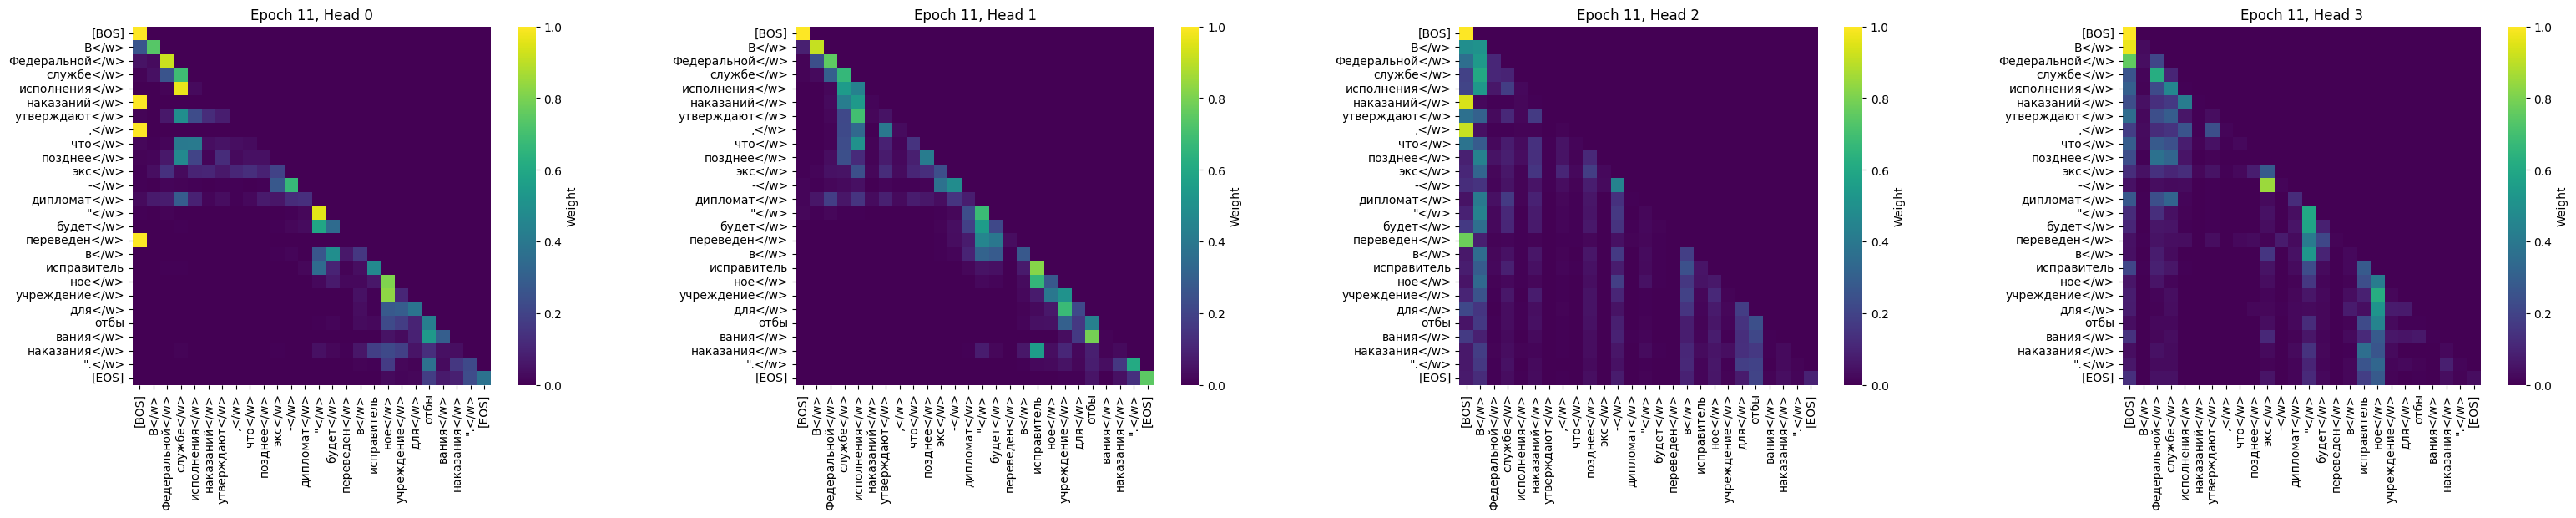

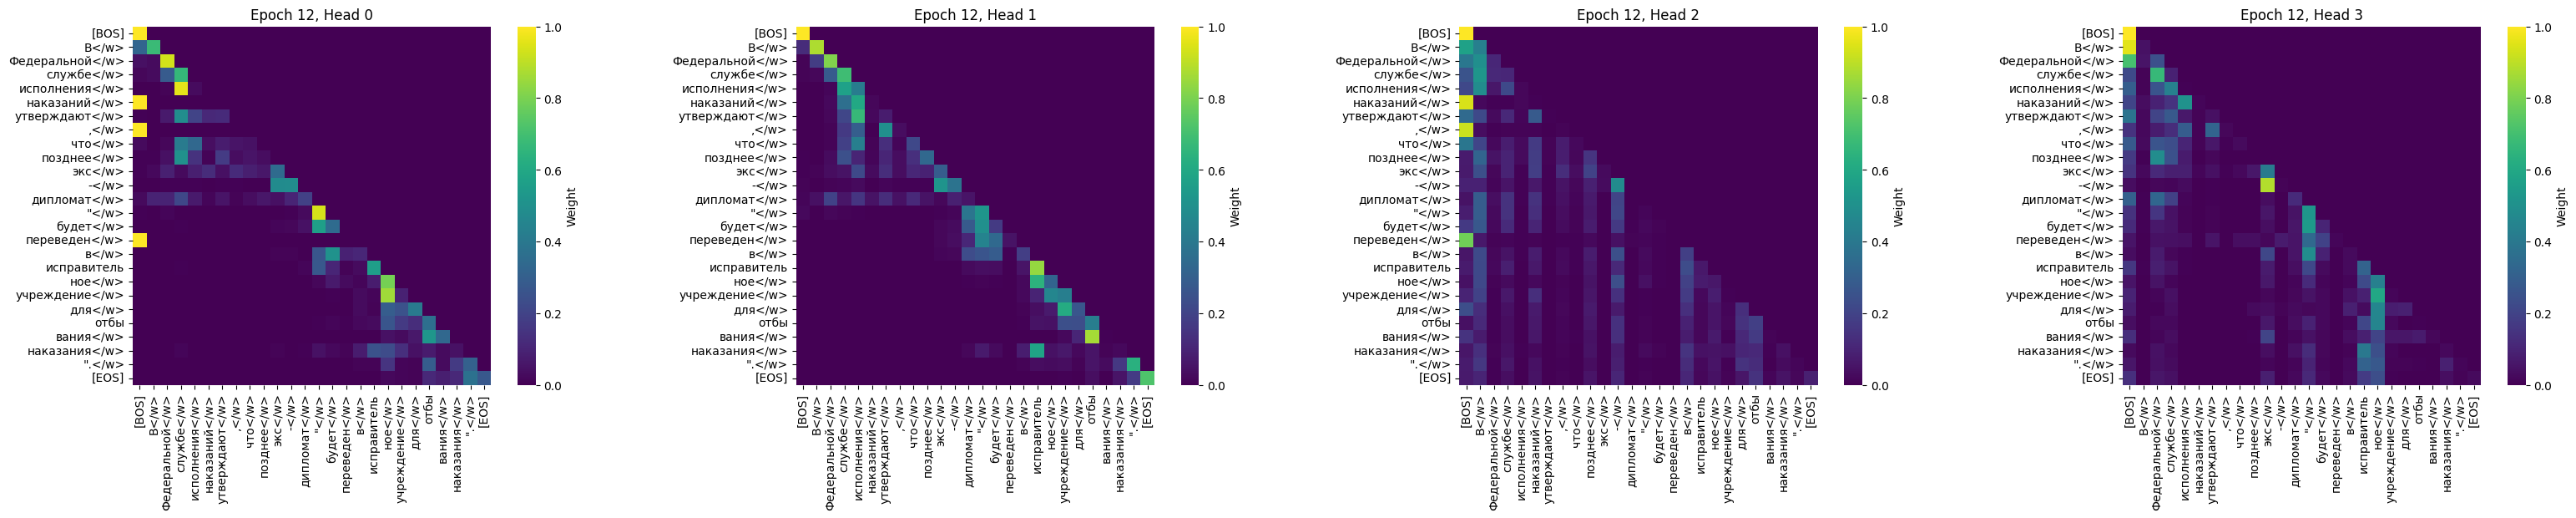

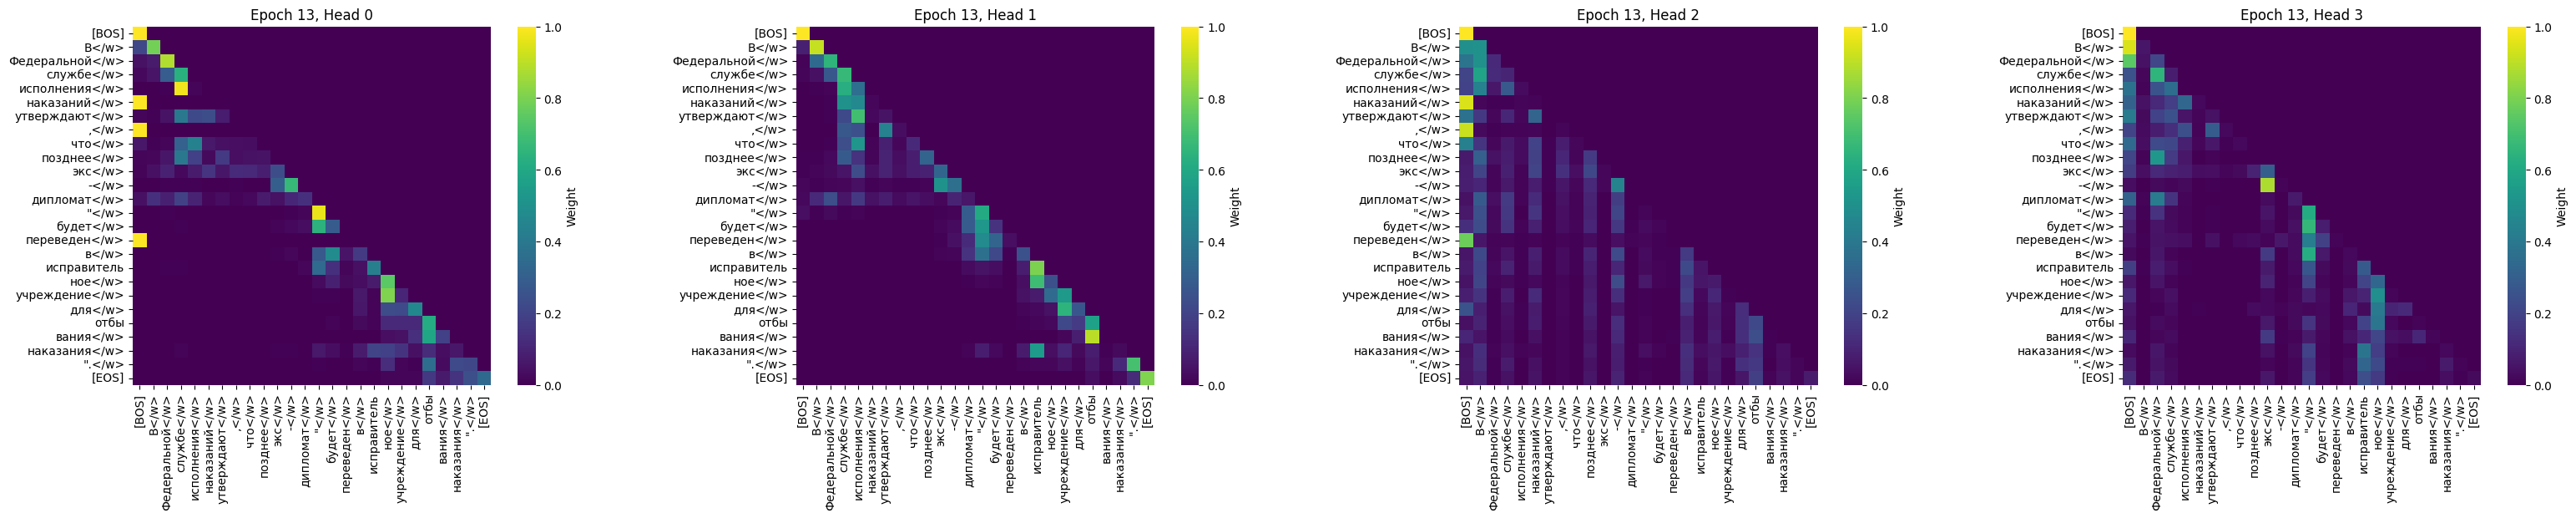

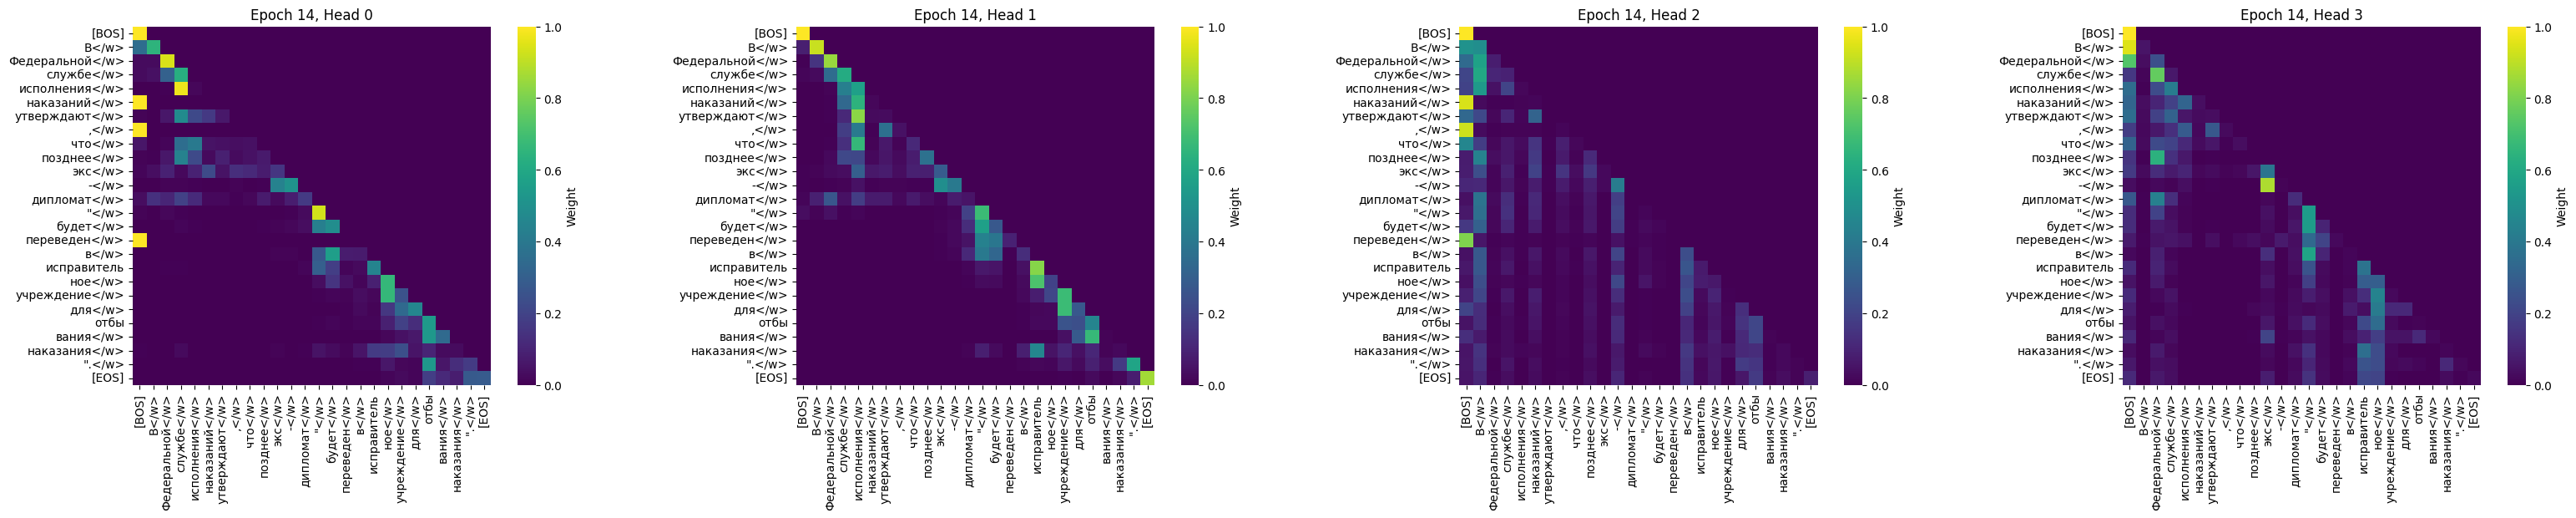

In [24]:
def visualize_results(attentions, sentence_idx, epoch):
    sentence_ids = val_set[sentence_idx][0]
    tokens = []
    for i in sentence_ids:
        if tokenizer.id_to_token(i) != '[PAD]':
            tokens.append(tokenizer.id_to_token(i) )

    max_length = attentions[epoch][-1][0].shape[0]
    actual_length = min(len(tokens), max_length)
    tokens = tokens[:len(tokens)]

    fig, axes = plt.subplots(1, 4, figsize=(8 * 4, 6))

    for head_idx in range(4):
        attention_matrix = attentions[epoch][-1][head_idx][:len(tokens), :len(tokens)]

        sns.heatmap(
            attention_matrix,
            cmap='viridis',
            ax=axes[head_idx],
            square=True,
            xticklabels=tokens,
            yticklabels=tokens,
            cbar_kws={"label": "Weight"}
        )
        axes[head_idx].set_title(f'Epoch {epoch}, Head {head_idx}')

    plt.tight_layout()

sentence_idx = 22888
for e in range(15):
    visualize_results(attentions_by_epoch, sentence_idx, epoch=e)